In [1]:
import pandas as pd
import numpy as np
from sklearn import tree, model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import graphviz

Считываем файл и из поля datetime делаем несколько категориальных признаков (час, день, месяц)

In [5]:
data = pd.read_csv("data/train.csv")
dt = pd.to_datetime(data["datetime"])
data["hour"] = dt.map(lambda x: x.hour)
data["day"] = dt.map(lambda x: x.day)
data["month"] = dt.map(lambda x: x.month)
data = data.drop(['datetime'], axis=1)

In [6]:
data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,month
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1,1
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,1,1
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,1,1
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,1,1


Найдем признак, с которым сильно коррелирует count 

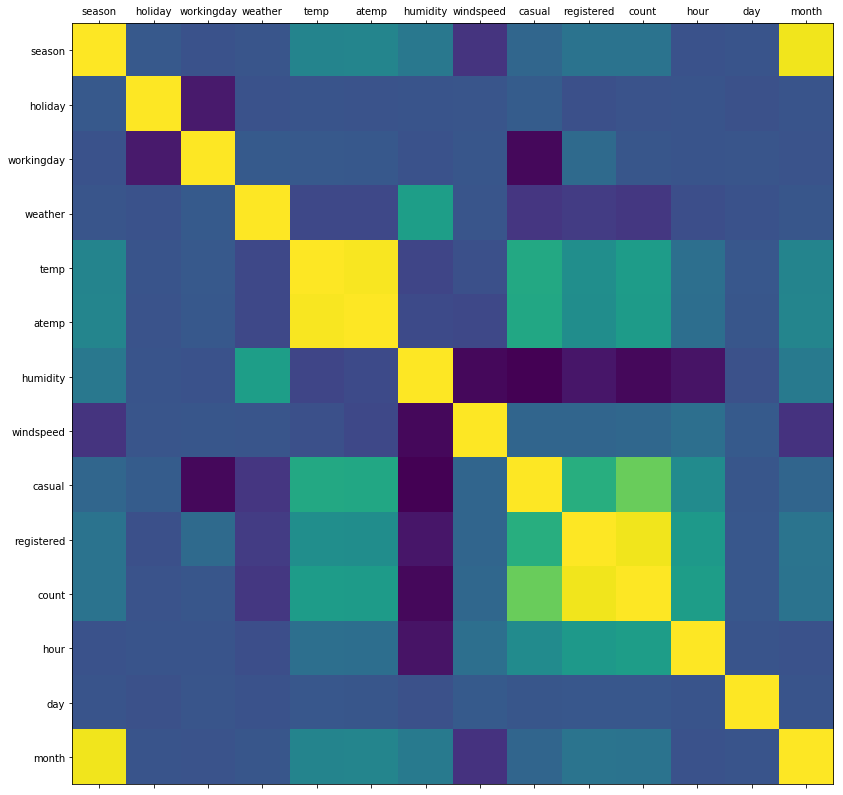

In [7]:
COUNT_COLUMNS = len(data.columns)
correlation = data.corr()
fig, ax = plt.subplots(figsize=(COUNT_COLUMNS, COUNT_COLUMNS))
ax.matshow(correlation)
plt.xticks(range(len(correlation.columns)), correlation.columns)
plt.yticks(range(len(correlation.columns)), correlation.columns)
plt.show()

их аж 2: 'registered' и 'casual'

In [8]:
data = data.drop(['registered', 'casual'], axis=1)

In [10]:
X_data = data.drop(['count'], axis=1)
Y_data = data['count']
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.25)

Строим дерево и считаем среднеквадратичную ошибку:

In [11]:
decisionTreeRegressor = DecisionTreeRegressor(random_state=12)
decisionTreeRegressor.fit(X_train.values, Y_train.values)
pred = decisionTreeRegressor.predict(X_test)

In [22]:
metrics.mean_squared_error(Y_test, pred)

7785.6858927259373

Функция для отрисовки дерева:

In [24]:
def getTreeView(decisionTreeRegressor):
    dot_data = tree.export_graphviz(decisionTreeRegressor, out_file=None,
                                filled=True, rounded=True, special_characters=True,
                                feature_names=X_data.columns, max_depth=5)
    graph = graphviz.Source(dot_data)
    graph.view()

In [25]:
getTreeView(decisionTreeRegressor)

Найдем оптимальные параметры:

In [17]:
gridSearch = model_selection.GridSearchCV(decisionTreeRegressor,
             {'max_depth': np.arange(4, 11),
              'criterion': ["mse", "mae"],
              'min_samples_split': np.arange(2, 7)}, 
              scoring='neg_mean_squared_error', cv=3)
gridSearch.fit(X_train, Y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=12, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': array([ 4,  5,  6,  7,  8,  9, 10]), 'criterion': ['mse', 'mae'], 'min_samples_split': array([2, 3, 4, 5, 6])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [20]:
gridSearch.best_params_

{'criterion': 'mse', 'max_depth': 9, 'min_samples_split': 3}

Минимальная ошибка:

In [21]:
-gridSearch.best_score_

7358.5680736086342

In [27]:
decisionTreeRegressor.set_params(**gridSearch.best_params_)
decisionTreeRegressor.fit(X_data, Y_data)

DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           presort=False, random_state=12, splitter='best')

In [28]:
getTreeView(decisionTreeRegressor)